In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import random
from scipy.special import logit, expit
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import statsmodels.api as sm

# Set a fixed random seed for reproducibility
random.seed(19)

df = pd.read_csv("../data/data_final.csv.gz")
df['date'] = pd.to_datetime(df['date'])
to_pred_df = df.loc[df['date'] >= pd.to_datetime('2017-01-01 00:00:00')].reset_index(drop=True)
df = df.loc[df['date'] < pd.to_datetime('2017-01-01 00:00:00')].reset_index(drop=True)

In [2]:


# General transformation function
def transform_fun(y, method='logit', scaler=1.0, epsilon=0.0, lmbda=None):
    """
    Apply a specified transformation (logit, box-cox, or yeo-johnson) to the target values.
    
    Parameters:
    - y: array-like, target values to be transformed
    - method: str, transformation method ('logit', 'box-cox', 'yeo-johnson')
    - scaler: float, scaling factor for methods requiring scaling (e.g., logit)
    - epsilon: float, small adjustment for boundaries in logit transformation
    - lmbda: float, lambda parameter for Box-Cox (if None, it will be estimated)
    
    Returns:
    - y_transformed: transformed target values
    - lmbda: lambda parameter used (only relevant for Box-Cox)
    """
    if method == 'logit':
        # Scale and apply epsilon adjustment
        y_adjusted = (y * scaler) * (1 - 2 * epsilon) + epsilon
        y_transformed = logit(y_adjusted)
        return y_transformed
    elif method == 'box-cox':
        if np.any(y <= 0):
            raise ValueError("Box-Cox transformation requires all y > 0.")
        y_transformed, lmbda = boxcox(y if lmbda is None else (y, lmbda))
        return y_transformed, lmbda
    elif method == 'yeo-johnson':
        pt = PowerTransformer(method='yeo-johnson', standardize=False)
        y_transformed = pt.fit_transform(y.reshape(-1, 1)).flatten()
        return y_transformed, pt
    else:
        raise ValueError("Invalid method. Choose 'logit', 'box-cox', or 'yeo-johnson'.")

    

# General inverse transformation function
def inverse_transform_fun(yhat_transformed, method='logit', scaler=1.0, epsilon=0.0, pt=None, lmbda=None):
    """
    Apply inverse transformation to the transformed predictions.
    
    Parameters:
    - yhat_transformed: array-like, transformed predictions to be converted back
    - method: str, transformation method used ('logit', 'box-cox', 'yeo-johnson')
    - scaler: float, scaling factor used in forward transformation (only for logit)
    - epsilon: float, small adjustment used in forward transformation (only for logit)
    - lmbda: float, lambda parameter used for Box-Cox transformation (if any)
    
    Returns:
    - yhat: predictions transformed back to the original scale
    """
    if method == 'logit':
        yhat_adjusted = expit(yhat_transformed)
        yhat = (yhat_adjusted - epsilon) / (1 - 2 * epsilon) / scaler
    elif method == 'box-cox':
        if lmbda is None:
            raise ValueError("Lambda value must be provided for inverse Box-Cox transformation.")
        yhat = np.exp(np.log(yhat_transformed * lmbda + 1) / lmbda) if lmbda != 0 else np.exp(yhat_transformed)
    elif method == 'yeo-johnson':
        if pt is None:
            raise ValueError("Fitted PowerTransform must be provided for inverse Yeo-Johnson transformation.")
        yhat = pt.inverse_transform(yhat_transformed.reshape(-1, 1)).flatten()
        return yhat
    else:
        raise ValueError("Invalid method. Choose 'logit', 'box-cox', or 'yeo-johnson'.")
    return yhat

# Define a custom MAPE scoring function
def mape(y_true, y_pred):
    # Avoid division by zero by adding a small constant to the denominator if necessary
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100

def smape(y_actual, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_actual) / (np.abs(y_actual) + np.abs(y_pred)))

def plot_predictions_vs_actuals(y_actual, y_pred, title="Predictions vs Actuals", fig_size=(8, 8), ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
    ax.scatter(y_actual, y_pred, alpha=0.6)
    ax.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)  # Line y=x
    ax.set_xlabel("Actual Values")
    ax.set_ylabel("Predicted Values")
    ax.set_title(title)
    ax.grid(True)
    return ax

def plot_residuals(y_actual, y_pred, title="Residual Plot", fig_size=(10, 6), ax=None):
    residuals = y_actual - y_pred
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
    ax.scatter(y_pred, residuals, alpha=0.6)
    ax.axhline(0, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel("Predicted Values")
    ax.set_ylabel("Residuals")
    ax.set_title(title)
    ax.grid(True)
    return ax

def plot_residual_histogram(y_actual, y_pred, bins=30, title="Histogram of Residuals", fig_size=(10, 6), ax=None):
    residuals = y_actual - y_pred
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
    sns.histplot(residuals, kde=True, bins=bins, color='blue', alpha=0.7, ax=ax)
    ax.axvline(0, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel("Residuals")
    ax.set_ylabel("Frequency")
    ax.set_title(title)
    return ax

def plot_cdf_of_absolute_errors(y_actual, y_pred, title="CDF of Absolute Errors", fig_size=(10, 6), ax=None):
    abs_errors = np.abs(y_actual - y_pred)
    sorted_errors = np.sort(abs_errors)
    cumulative_distribution = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
    ax.plot(sorted_errors, cumulative_distribution, marker='.', linestyle='-', color='blue')
    ax.set_xlabel("Absolute Error")
    ax.set_ylabel("Cumulative Probability")
    ax.set_title(title)
    ax.grid(True)
    return ax

def plot_qq_plot(y_actual, y_pred, title="Q-Q Plot of Residuals", fig_size=(8, 8), ax=None):
    residuals = y_actual - y_pred
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
    sm.qqplot(residuals, line='s', ax=ax)
    ax.set_title(title)
    ax.grid(True)
    return ax

def plot_residuals_boxplot(y_actual, y_pred, title="Box Plot of Residuals", fig_size=(10, 6), ax=None):
    residuals = y_actual - y_pred
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
    sns.boxplot(data=residuals, orient='h', ax=ax)
    ax.set_xlabel("Residuals")
    ax.set_title(title)
    ax.grid(True)
    return ax

def plot_cooks_distance(X, y, title="Cook's Distance Plot", fig_size=(10, 6), ax=None):
    X_with_const = sm.add_constant(X)  # Add constant for intercept
    model = sm.OLS(y, X_with_const).fit()
    influence = model.get_influence()
    cooks_d = influence.cooks_distance[0]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=fig_size)
    ax.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ")
    ax.axhline(4 / len(cooks_d), color='red', linestyle='--', label='Threshold Line')
    ax.set_xlabel("Observation Index")
    ax.set_ylabel("Cook's Distance")
    ax.set_title(title)
    ax.grid(True)
    ax.legend()
    return ax

In [3]:

tiles = df['tile_index'].unique().tolist()
random.shuffle(tiles)

train_ratio = 0.75
split_index = int(train_ratio * len(tiles))
train_tiles = tiles[:split_index] 
test_tiles = tiles[split_index:]  

train_df = df.loc[df['tile_index'].isin(train_tiles)]
test_df = df.loc[df['tile_index'].isin(test_tiles)]

X_cols = [col for col in df.columns if col.startswith('feature')]
y_col = 'avg_urban_imperviousness'


X_train = train_df[X_cols]
y_train = train_df[y_col]
y_train_transformed = y_train.apply(lambda y: transform_fun(y, 'logit', 1/100, 10e-6))

X_test = test_df[X_cols]
y_test = test_df[y_col]
y_test_transformed = y_test.apply(lambda y: transform_fun(y, 'logit', 1/100, 10e-6))

In [4]:
X_train.shape

(13395, 768)

In [5]:
print("Original target distribution:")
print(y_train.describe())
print("\nTransformed target distribution (to ensure final output is 0% <= yhat <= 100%):")
print(y_train_transformed.describe())

Original target distribution:
count    13395.000000
mean         3.168552
std          5.665507
min          0.000000
25%          0.355177
50%          1.382693
75%          3.241756
max         59.641462
Name: avg_urban_imperviousness, dtype: float64

Transformed target distribution (to ensure final output is 0% <= yhat <= 100%):
count    13395.000000
mean        -5.099364
std          2.827213
min        -11.512915
25%         -5.633948
50%         -4.266501
75%         -3.395802
max          0.390540
Name: avg_urban_imperviousness, dtype: float64


**Training Data Context**:

  - The mean value of the target variable, `avg_urban_imperviousness`, is approximately 3.21, with a relatively 
    high standard deviation of 5.79.
  -  The data distribution is skewed, with the 75th percentile at 3.23 and a maximum value of 59.64. This suggests 
    that while most values are concentrated at the lower end, there are significant outliers with high imperviousness.

In [6]:
# Create the directory path for storing the models
models_dir = "../artifacts/models"
os.makedirs(models_dir, exist_ok=True)

In [7]:
# Establish a baseline model using the mean (no transformations needed here)
baseline_pred = np.full_like(y_test, y_train.mean(), dtype=np.float64)

# Calculate baseline performance
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_r2 = r2_score(y_test, baseline_pred)
print(f"Baseline RMSE: {baseline_rmse:.4f}")
print(f"Baseline R^2: {baseline_r2:.4f}")

Baseline RMSE: 6.0941
Baseline R^2: -0.0002


In [8]:
# Simple Linear Regression
lr_model_path = os.path.join(models_dir, 'linear_regression.pkl')
if not os.path.exists(lr_model_path):
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train_transformed)
    with open(lr_model_path, 'wb') as f:
        pickle.dump(lr_model, f)
else:
    with open(lr_model_path, 'rb') as f:
        lr_model = pickle.load(f)
lr_pred_transformed = lr_model.predict(X_test)

# Transform predictions back to the original scale using inverse_transform_fun
lr_pred = inverse_transform_fun(lr_pred_transformed, 'logit', scaler=1/100, epsilon=10e-6)

# Evaluate Linear Regression model
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)
print(f"Linear Regression RMSE: {lr_rmse:.4f}")
print(f"Linear Regression R^2: {lr_r2:.4f}")

Linear Regression RMSE: 3.8787
Linear Regression R^2: 0.5948


In [9]:
# PCA
pca_95n_path = os.path.join(models_dir, 'pca_95n.pkl')
if not os.path.exists(pca_95n_path):
    pca = PCA(n_components=0.95)  # Retain 95% of the variance
    X_train_pca = pca.fit_transform(X_train)
    with open(pca_95n_path, 'wb') as f:
        pickle.dump(pca, f)
else:
    with open(pca_95n_path, 'rb') as f:
        pca = pickle.load(f)
        X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [10]:
# PCA + Linear Regression
lr_pca_model_path = os.path.join(models_dir, 'pca_linear_regression.pkl')
if not os.path.exists(lr_pca_model_path):
    lr_pca_model = LinearRegression()
    lr_pca_model.fit(X_train_pca, y_train_transformed)
    with open(lr_pca_model_path, 'wb') as f:
        pickle.dump(lr_pca_model, f)
else:
    with open(lr_pca_model_path, 'rb') as f:
        lr_pca_model = pickle.load(f)
lr_pca_pred_transformed = lr_pca_model.predict(X_test_pca)

# Transform predictions back to the original scale using inverse_transform_fun(
lr_pca_pred = inverse_transform_fun(lr_pca_pred_transformed, 'logit', scaler=1/100, epsilon=10e-6)

# Evaluate PCA + Linear Regression model
lr_pca_rmse = np.sqrt(mean_squared_error(y_test, lr_pca_pred))
lr_pca_r2 = r2_score(y_test, lr_pca_pred)
print(f"PCA + Linear Regression RMSE: {lr_pca_rmse:.4f}")
print(f"PCA + Linear Regression R^2: {lr_pca_r2:.4f}")

PCA + Linear Regression RMSE: 3.7799
PCA + Linear Regression R^2: 0.6152


In [11]:
# LASSO Regression with Cross-Validation
lasso_model_path = os.path.join(models_dir, 'lasso_regression.pkl')
if not os.path.exists(lasso_model_path):
    lasso_model = LassoCV(alphas=np.logspace(-4, 0, 50), cv=5, n_jobs=4)
    lasso_model.fit(X_train, y_train_transformed)
    with open(lasso_model_path, 'wb') as f:
        pickle.dump(lasso_model, f)
else:
    with open(lasso_model_path, 'rb') as f:
        lasso_model = pickle.load(f)
lasso_pred_transformed = lasso_model.predict(X_test)

# Transform predictions back to the original scale using inverse_transform_fun
lasso_pred = inverse_transform_fun(lasso_pred_transformed, 'logit', scaler=1/100, epsilon=10e-6)

# Evaluate LASSO model
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))
lasso_r2 = r2_score(y_test, lasso_pred)
print(f"LASSO Regression RMSE: {lasso_rmse:.4f}")
print(f"LASSO Regression R^2: {lasso_r2:.4f}")
print(f"Optimal alpha for LASSO: {lasso_model.alpha_:.4e}")

LASSO Regression RMSE: 3.6169
LASSO Regression R^2: 0.6477
Optimal alpha for LASSO: 3.7276e-04


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 13395, number of used features: 768
[LightGBM] [Info] Start training from score -1.899019
LightGBM RMSE: 3.1411
LightGBM R^2: 0.7343


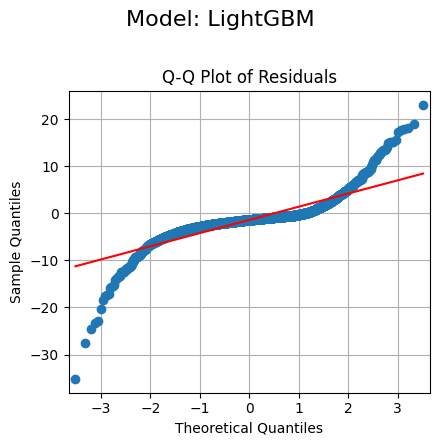

In [20]:
# LightGBM with Cross-Validation for Hyperparameter Tuning
lgb_model_path = os.path.join(models_dir, 'lightgbm.pkl')
if not os.path.exists(lgb_model_path):
    lgb_model = LGBMRegressor(objective='quantile', 
                              alpha=0.95, 
                              num_leaves=20, 
                              learning_rate=0.1, 
                              n_estimators=5000,
                              reg_alpha=0.0, 
                              reg_lambda=0.9, 
                              random_state=19,
                              n_jobs=4)
    lgb_model.fit(X_train, y_train_transformed.values)
    with open(lgb_model_path, 'wb') as f:
        pickle.dump(lgb_model, f)
else:
    with open(lgb_model_path, 'rb') as f:
        lgb_model = pickle.load(f)
lgb_pred_transformed = lgb_model.predict(X_test)

# Transform predictions back to the original scale using inverse_transform_fun
lgb_pred = inverse_transform_fun(lgb_pred_transformed, 'logit', scaler=1/100, epsilon=10e-6)

# Evaluate LightGBM model
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
lgb_r2 = r2_score(y_test, lgb_pred)
print(f"LightGBM RMSE: {lgb_rmse:.4f}")
print(f"LightGBM R^2: {lgb_r2:.4f}")

fig, axs = plt.subplots(1, 1, figsize=(4.5, 4.5)) 
fig.suptitle("Model: LightGBM", fontsize=16)
plot_qq_plot(y_test, lgb_pred, "Q-Q Plot of Residuals", ax=axs)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout and title spacing
plt.show()

In [ ]:
pd.DataFrame({'feature':lgb_model.feature_name_, 'imp':lgb_model.feature_importances_}).sort_values(by='imp')

,feature,imp
0,feature_0,69
1,feature_1,283
2,feature_2,162
3,feature_3,75
4,feature_4,175
...,...,...
763,feature_763,65
764,feature_764,166
765,feature_765,91
766,feature_766,95


: 

In [21]:
feature_imps = pd.DataFrame({'feature':lgb_model.feature_name_, 'imp':lgb_model.feature_importances_})
top_features = feature_imps[feature_imps.imp < 1]['feature'].tolist()

# Create the custom scorer
mape_scorer = make_scorer(mape, greater_is_better=False)  # Set to False as lower MAPE is better

# LightGBM with Cross-Validation for Hyperparameter Tuning for top features
lgb_tf_model_path = os.path.join(models_dir, 'lightgbm_top_features.pkl')
if not os.path.exists(lgb_tf_model_path):
    lgb_tf_model = LGBMRegressor(objective='regression', random_state=19)
    lgb_tf_param_grid = {
        'num_leaves': [20],
        'learning_rate': [0.1],
        'n_estimators': [100]
    }

    lgb_tf_cv = GridSearchCV(lgb_tf_model, lgb_tf_param_grid, cv=5, n_jobs=4, scoring=mape_scorer)
    lgb_tf_cv.fit(X_train[top_features], y_train_transformed.values.ravel())
    lgb_tf_best = lgb_tf_cv.best_estimator_
    print(f"Best params for LightGBM with Top Features: {lgb_tf_cv.best_params_}")
    with open(lgb_tf_model_path, 'wb') as f:
        pickle.dump(lgb_tf_best, f)
else:
    with open(lgb_tf_model_path, 'rb') as f:
        lgb_tf_best = pickle.load(f)
lgb_tf_pred_transformed = lgb_tf_best.predict(X_test[top_features])

# Transform predictions back to the original scale using inverse_transform_fun
lgb_tf_pred = inverse_transform_fun(lgb_tf_pred_transformed, 'logit', scaler=1/100, epsilon=10e-6)

# Evaluate LightGBM model
lgb_tf_rmse = np.sqrt(mean_squared_error(y_test, lgb_tf_pred))
lgb_tf_r2 = r2_score(y_test, lgb_tf_pred)
print(f"LightGBM RMSE with Top Features: {lgb_tf_rmse:.4f}")
print(f"LightGBM R^2 with Top Features: {lgb_tf_r2:.4f}")


fig, axs = plt.subplots(1, 1, figsize=(4.5, 4.5)) 
fig.suptitle("Model: LightGBM with Top Features", fontsize=16)
plot_qq_plot(y_test, lgb_tf_pred, "Q-Q Plot of Residuals", ax=axs)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout and title spacing
plt.show()


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\btripp\urban-clay\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\btripp\urban-clay\env\Lib\site-packages\lightgbm\sklearn.py", line 1189, in fit
    super().fit(
  File "c:\Users\btripp\urban-clay\env\Lib\site-packages\lightgbm\sklearn.py", line 955, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\btripp\urban-clay\env\Lib\site-packages\lightgbm\engine.py", line 282, in train
    booster = Booster(params=params, train_set=train_set)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\btripp\urban-clay\env\Lib\site-packages\lightgbm\basic.py", line 3641, in __init__
    _safe_call(
  File "c:\Users\btripp\urban-clay\env\Lib\site-packages\lightgbm\basic.py", line 296, in _safe_call
    raise LightGBMError(_LIB.LGBM_GetLastError().decode("utf-8"))
lightgbm.basic.LightGBMError: Forced splits file includes feature index 0, but maximum feature index in dataset is -1


                     Model      RMSE       R^2
0                 Baseline  6.227590 -0.003194
1        Linear Regression  4.270622  0.528233
2  PCA + Linear Regression  4.415851  0.495602
3         LASSO Regression  4.012070  0.583628
4                 LightGBM  3.288466  0.720275


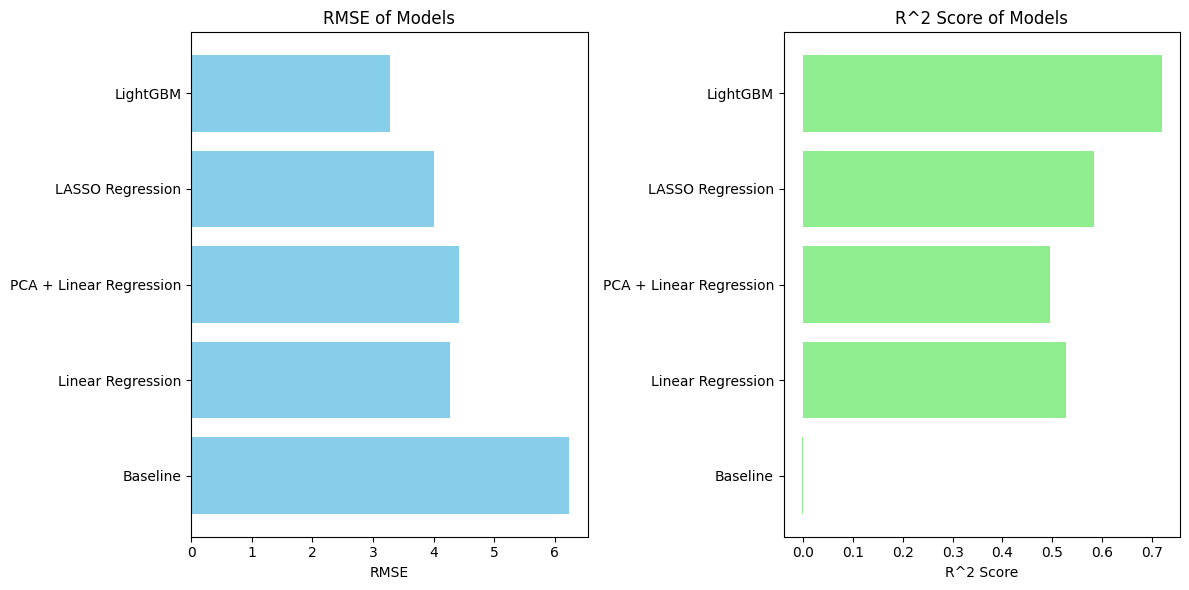

In [ ]:
models = {
    'baseline': baseline_pred,  # Note: this is not a model, just predictions; saving for consistency
    'linear_regression': lr_model,
    'pca_linear_regression': lr_pca_model,
    'lasso_regression': lasso_model,
    'lightgbm': lgb_model
}

# Create a dictionary to store the model results
results = {
    'Model': ['Baseline', 'Linear Regression', 'PCA + Linear Regression', 'LASSO Regression', 'LightGBM'],
    'RMSE': [baseline_rmse, lr_rmse, lr_pca_rmse, lasso_rmse, lgb_rmse],
    'R^2': [baseline_r2, lr_r2, lr_pca_r2, lasso_r2, lgb_r2]
}

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results)

# Display the results DataFrame
print(results_df)

# Plot the scores for easy comparison
plt.figure(figsize=(12, 6))

# RMSE Plot
plt.subplot(1, 2, 1)
plt.barh(results_df['Model'], results_df['RMSE'], color='skyblue')
plt.xlabel('RMSE')
plt.title('RMSE of Models')

# R^2 Plot
plt.subplot(1, 2, 2)
plt.barh(results_df['Model'], results_df['R^2'], color='lightgreen')
plt.xlabel('R^2 Score')
plt.title('R^2 Score of Models')

plt.tight_layout()
plt.show()

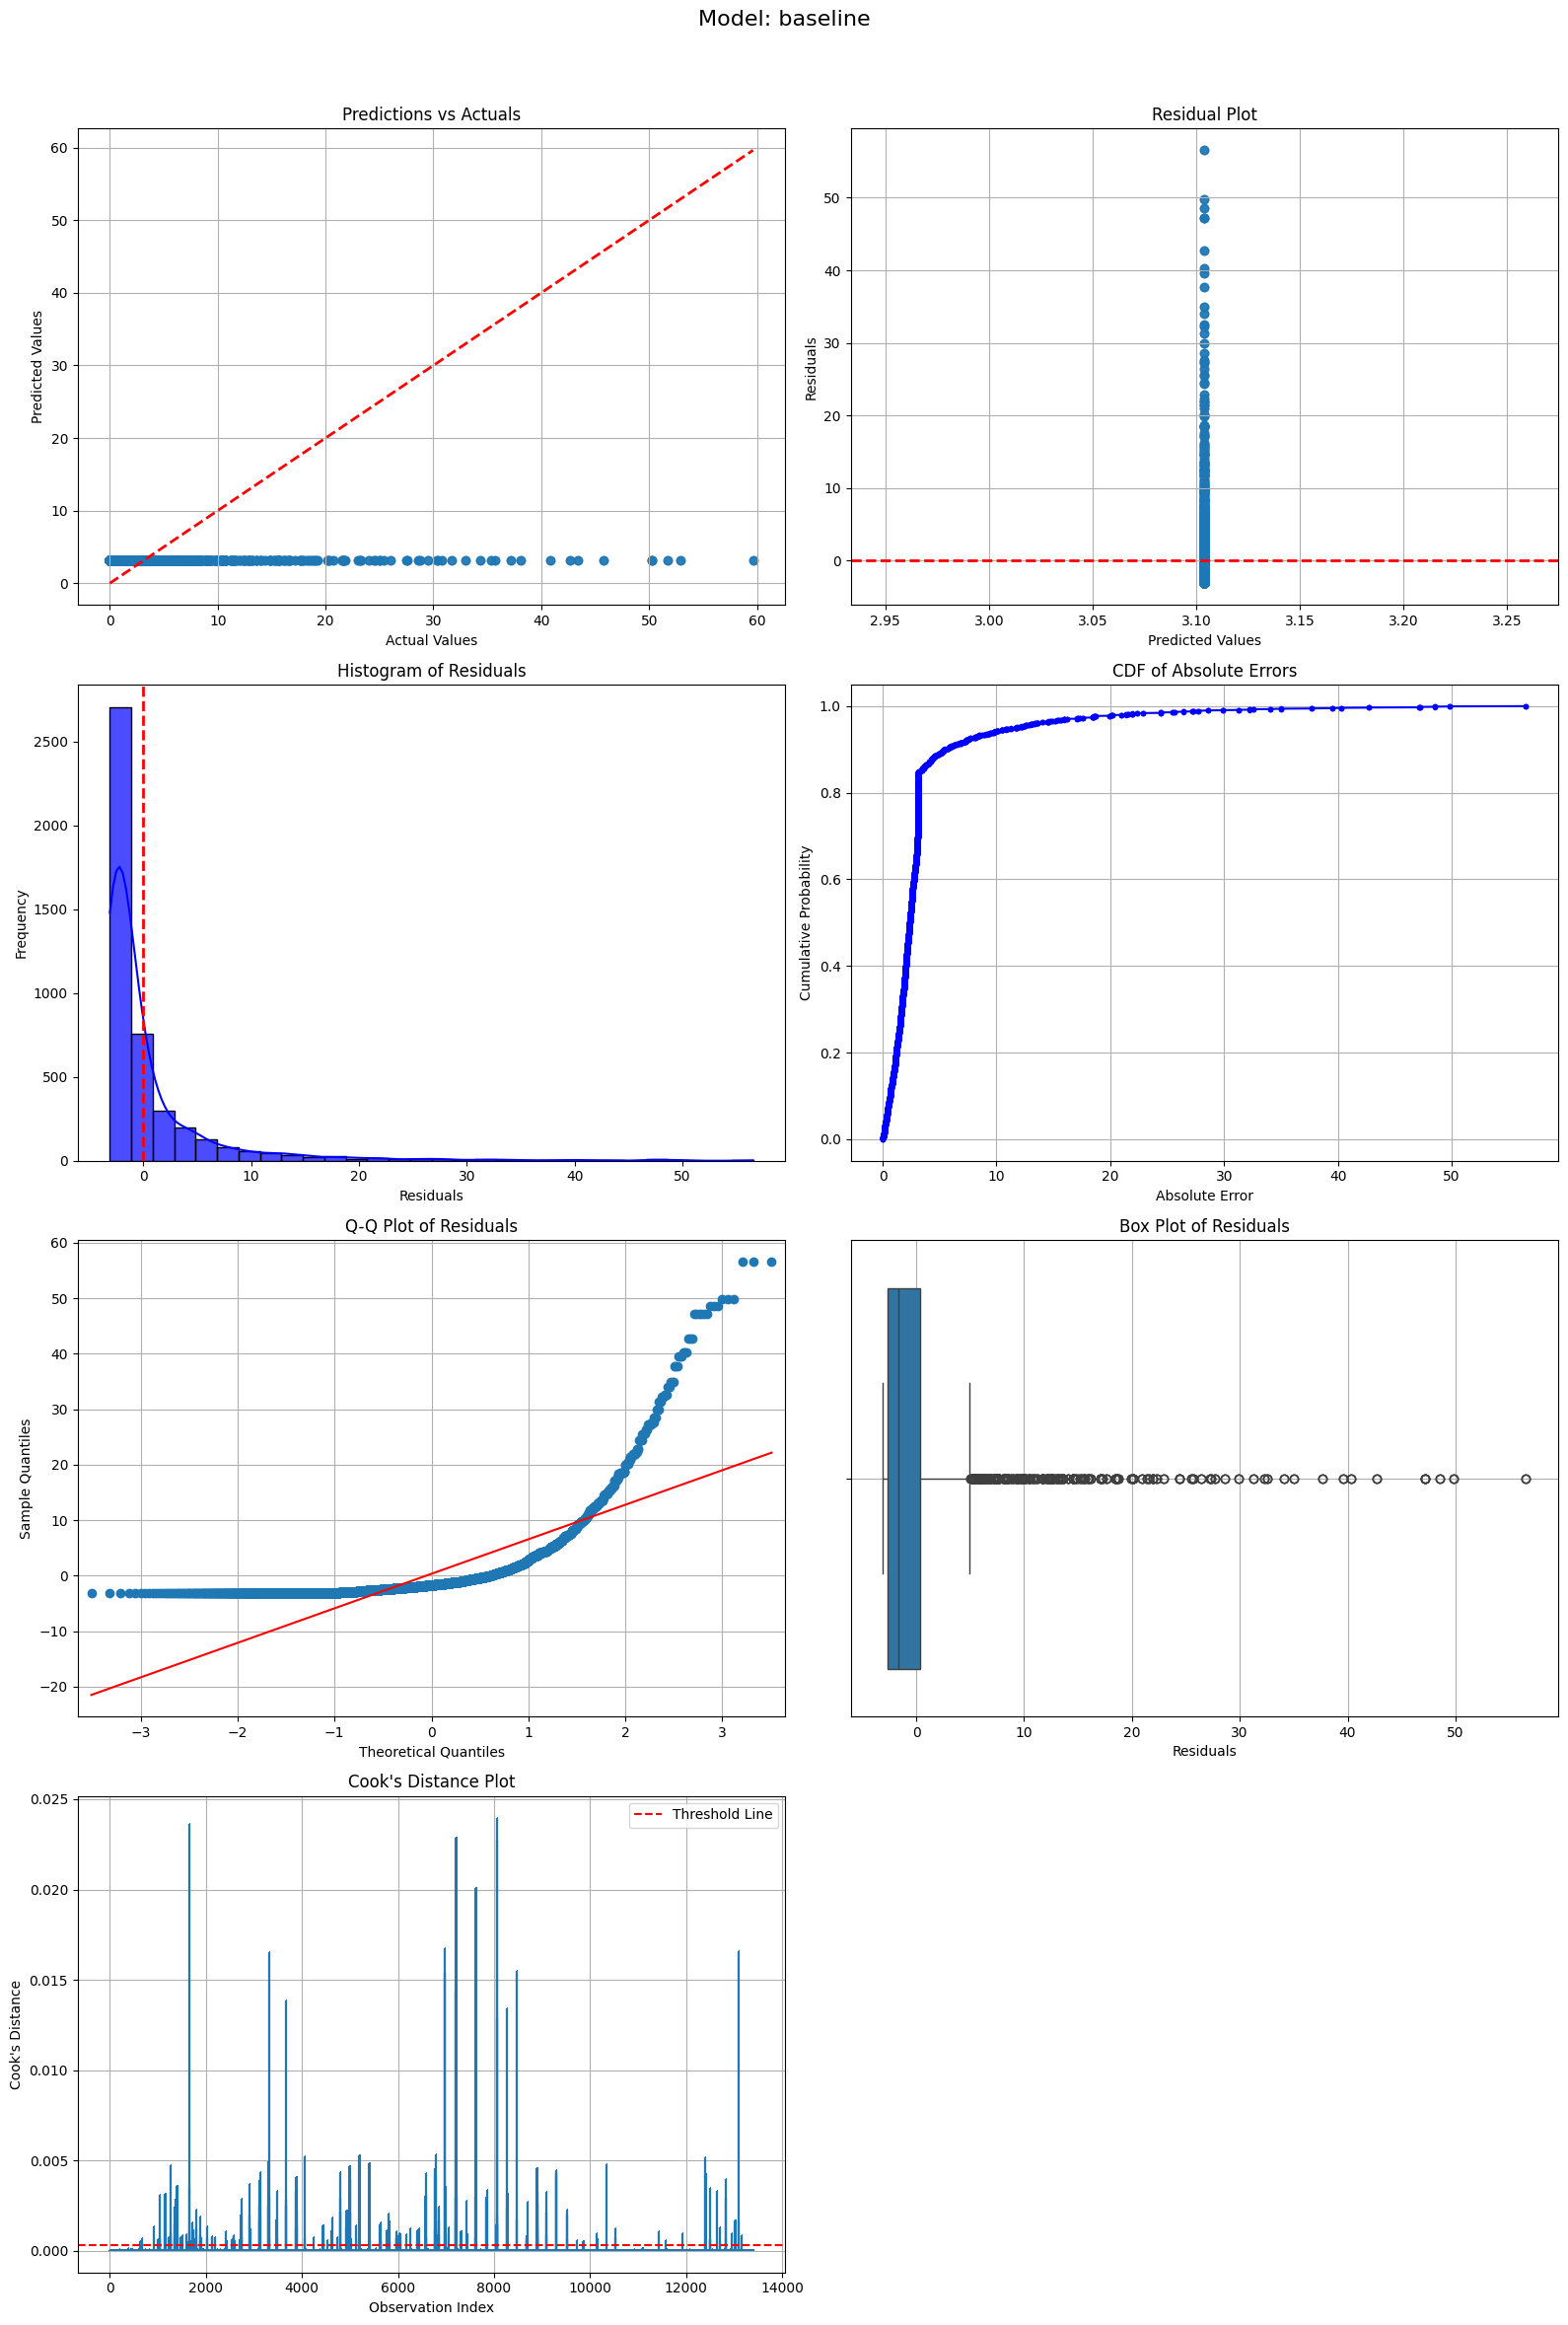

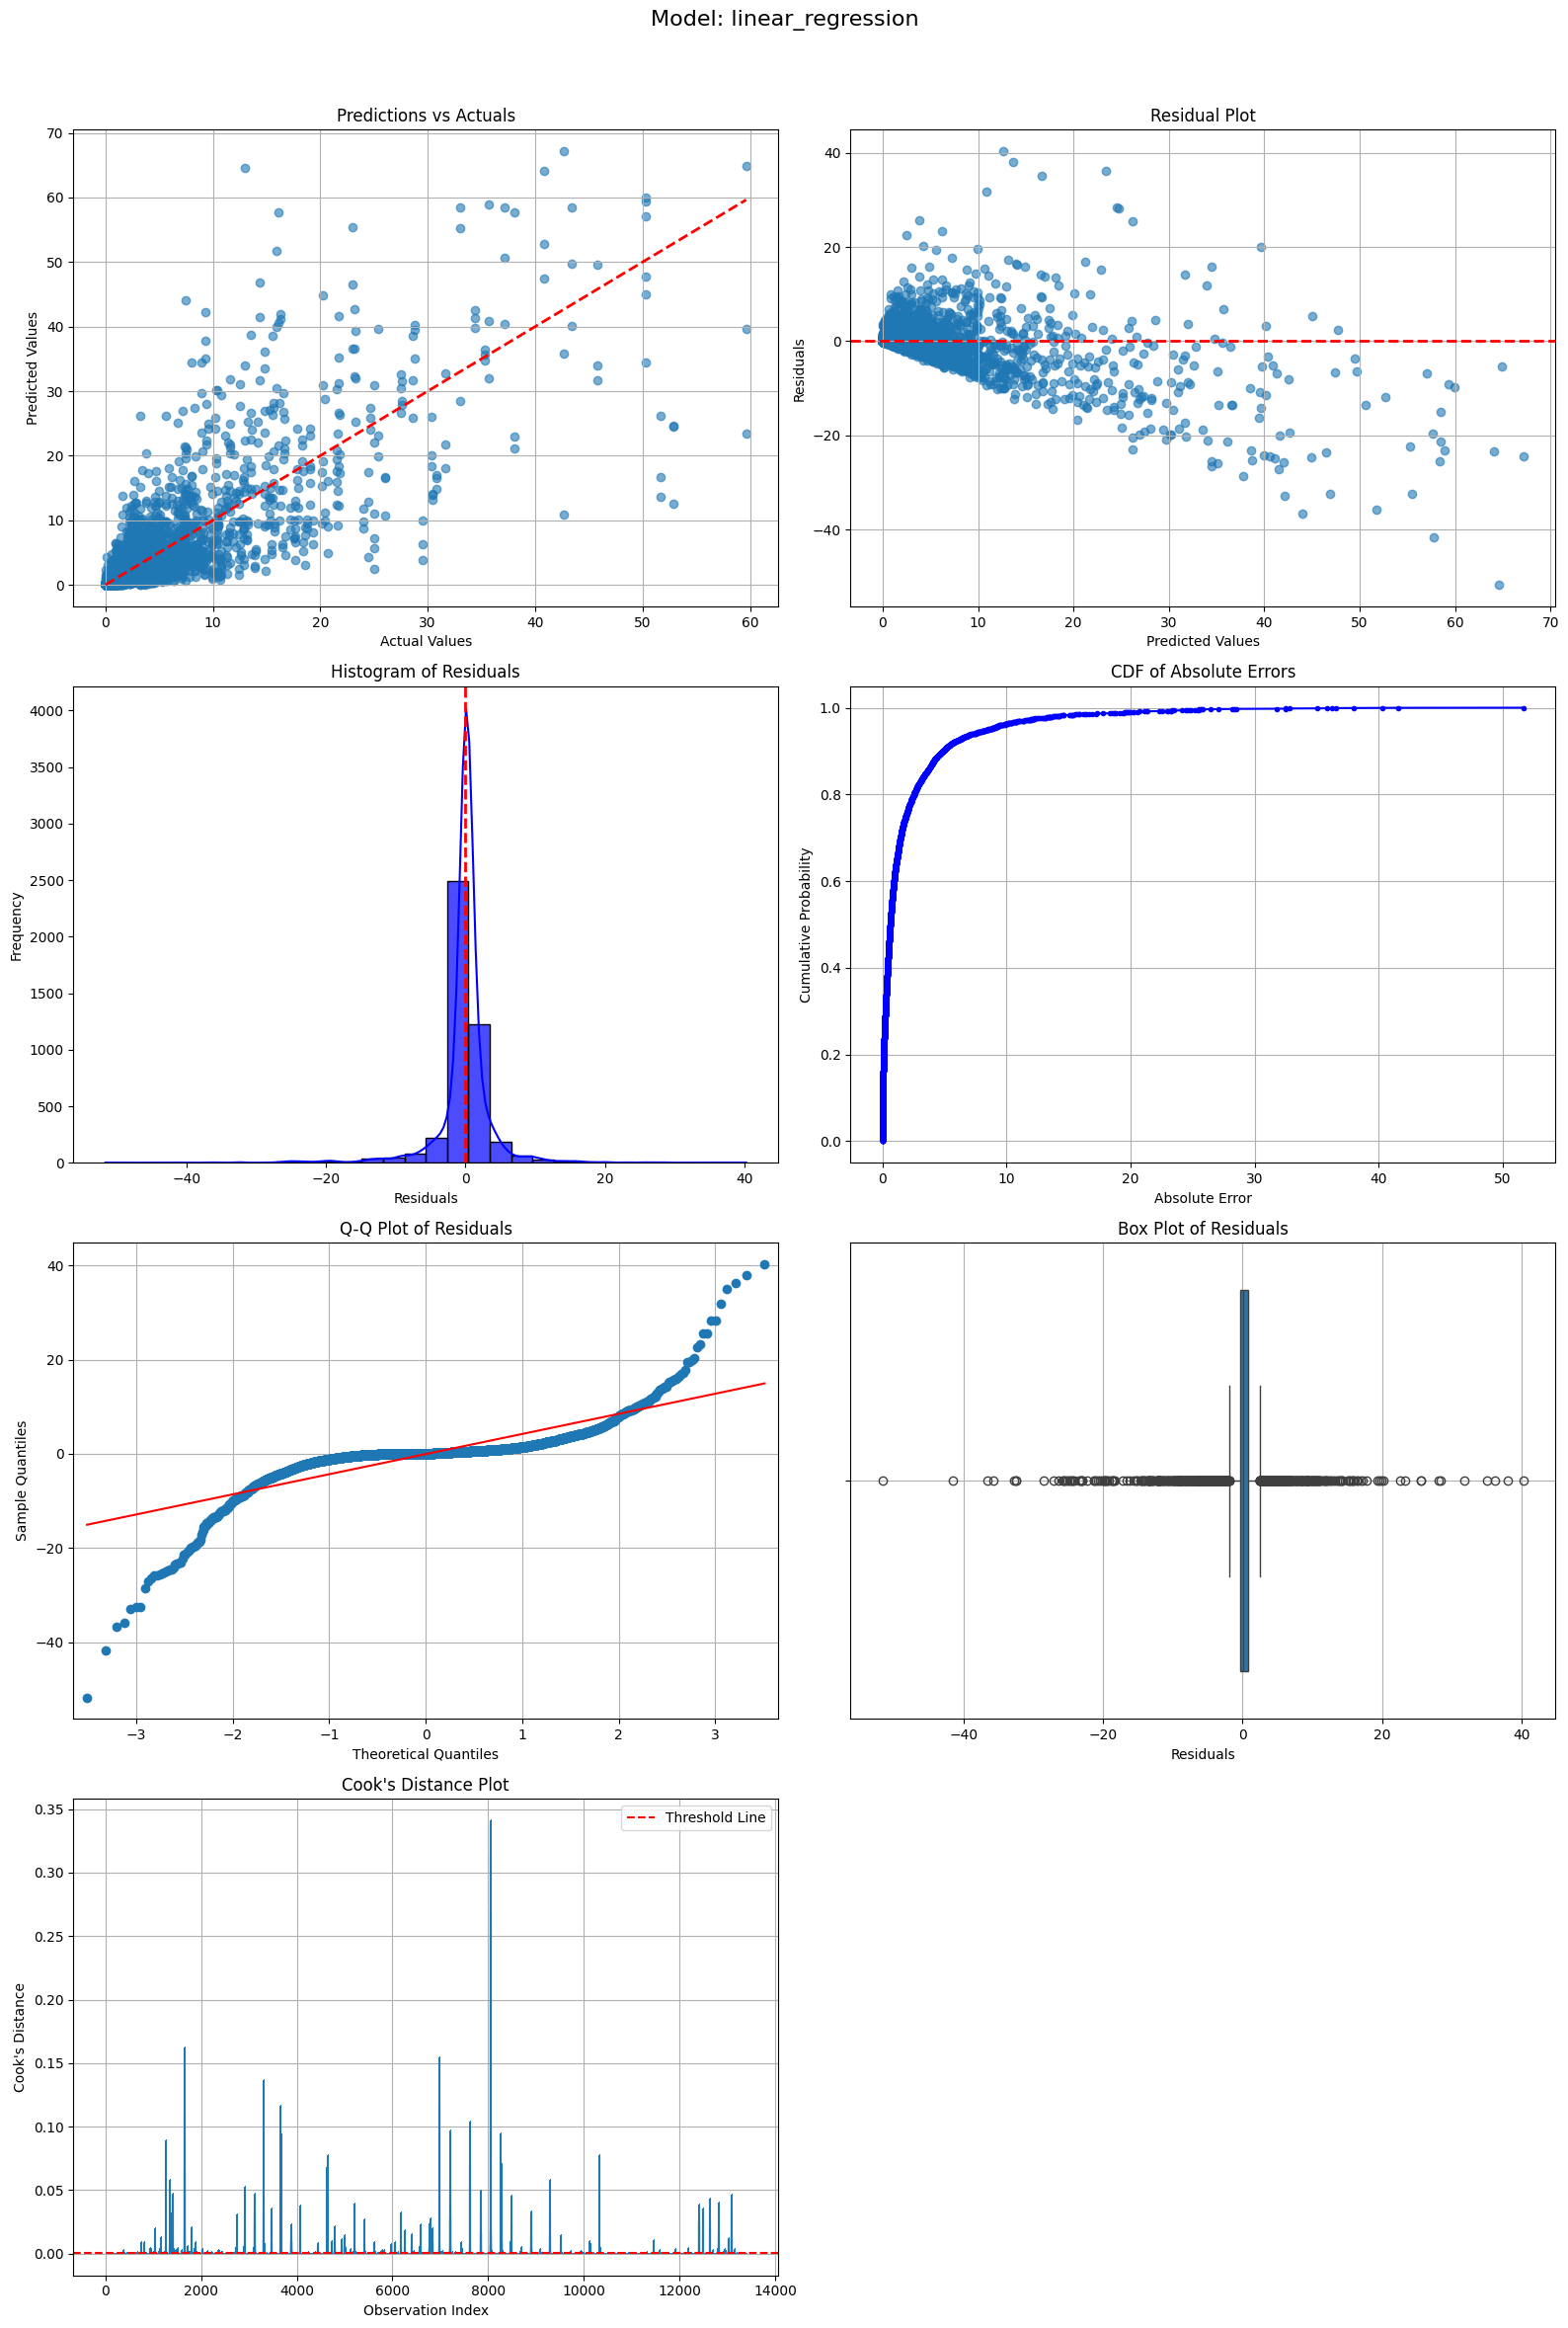

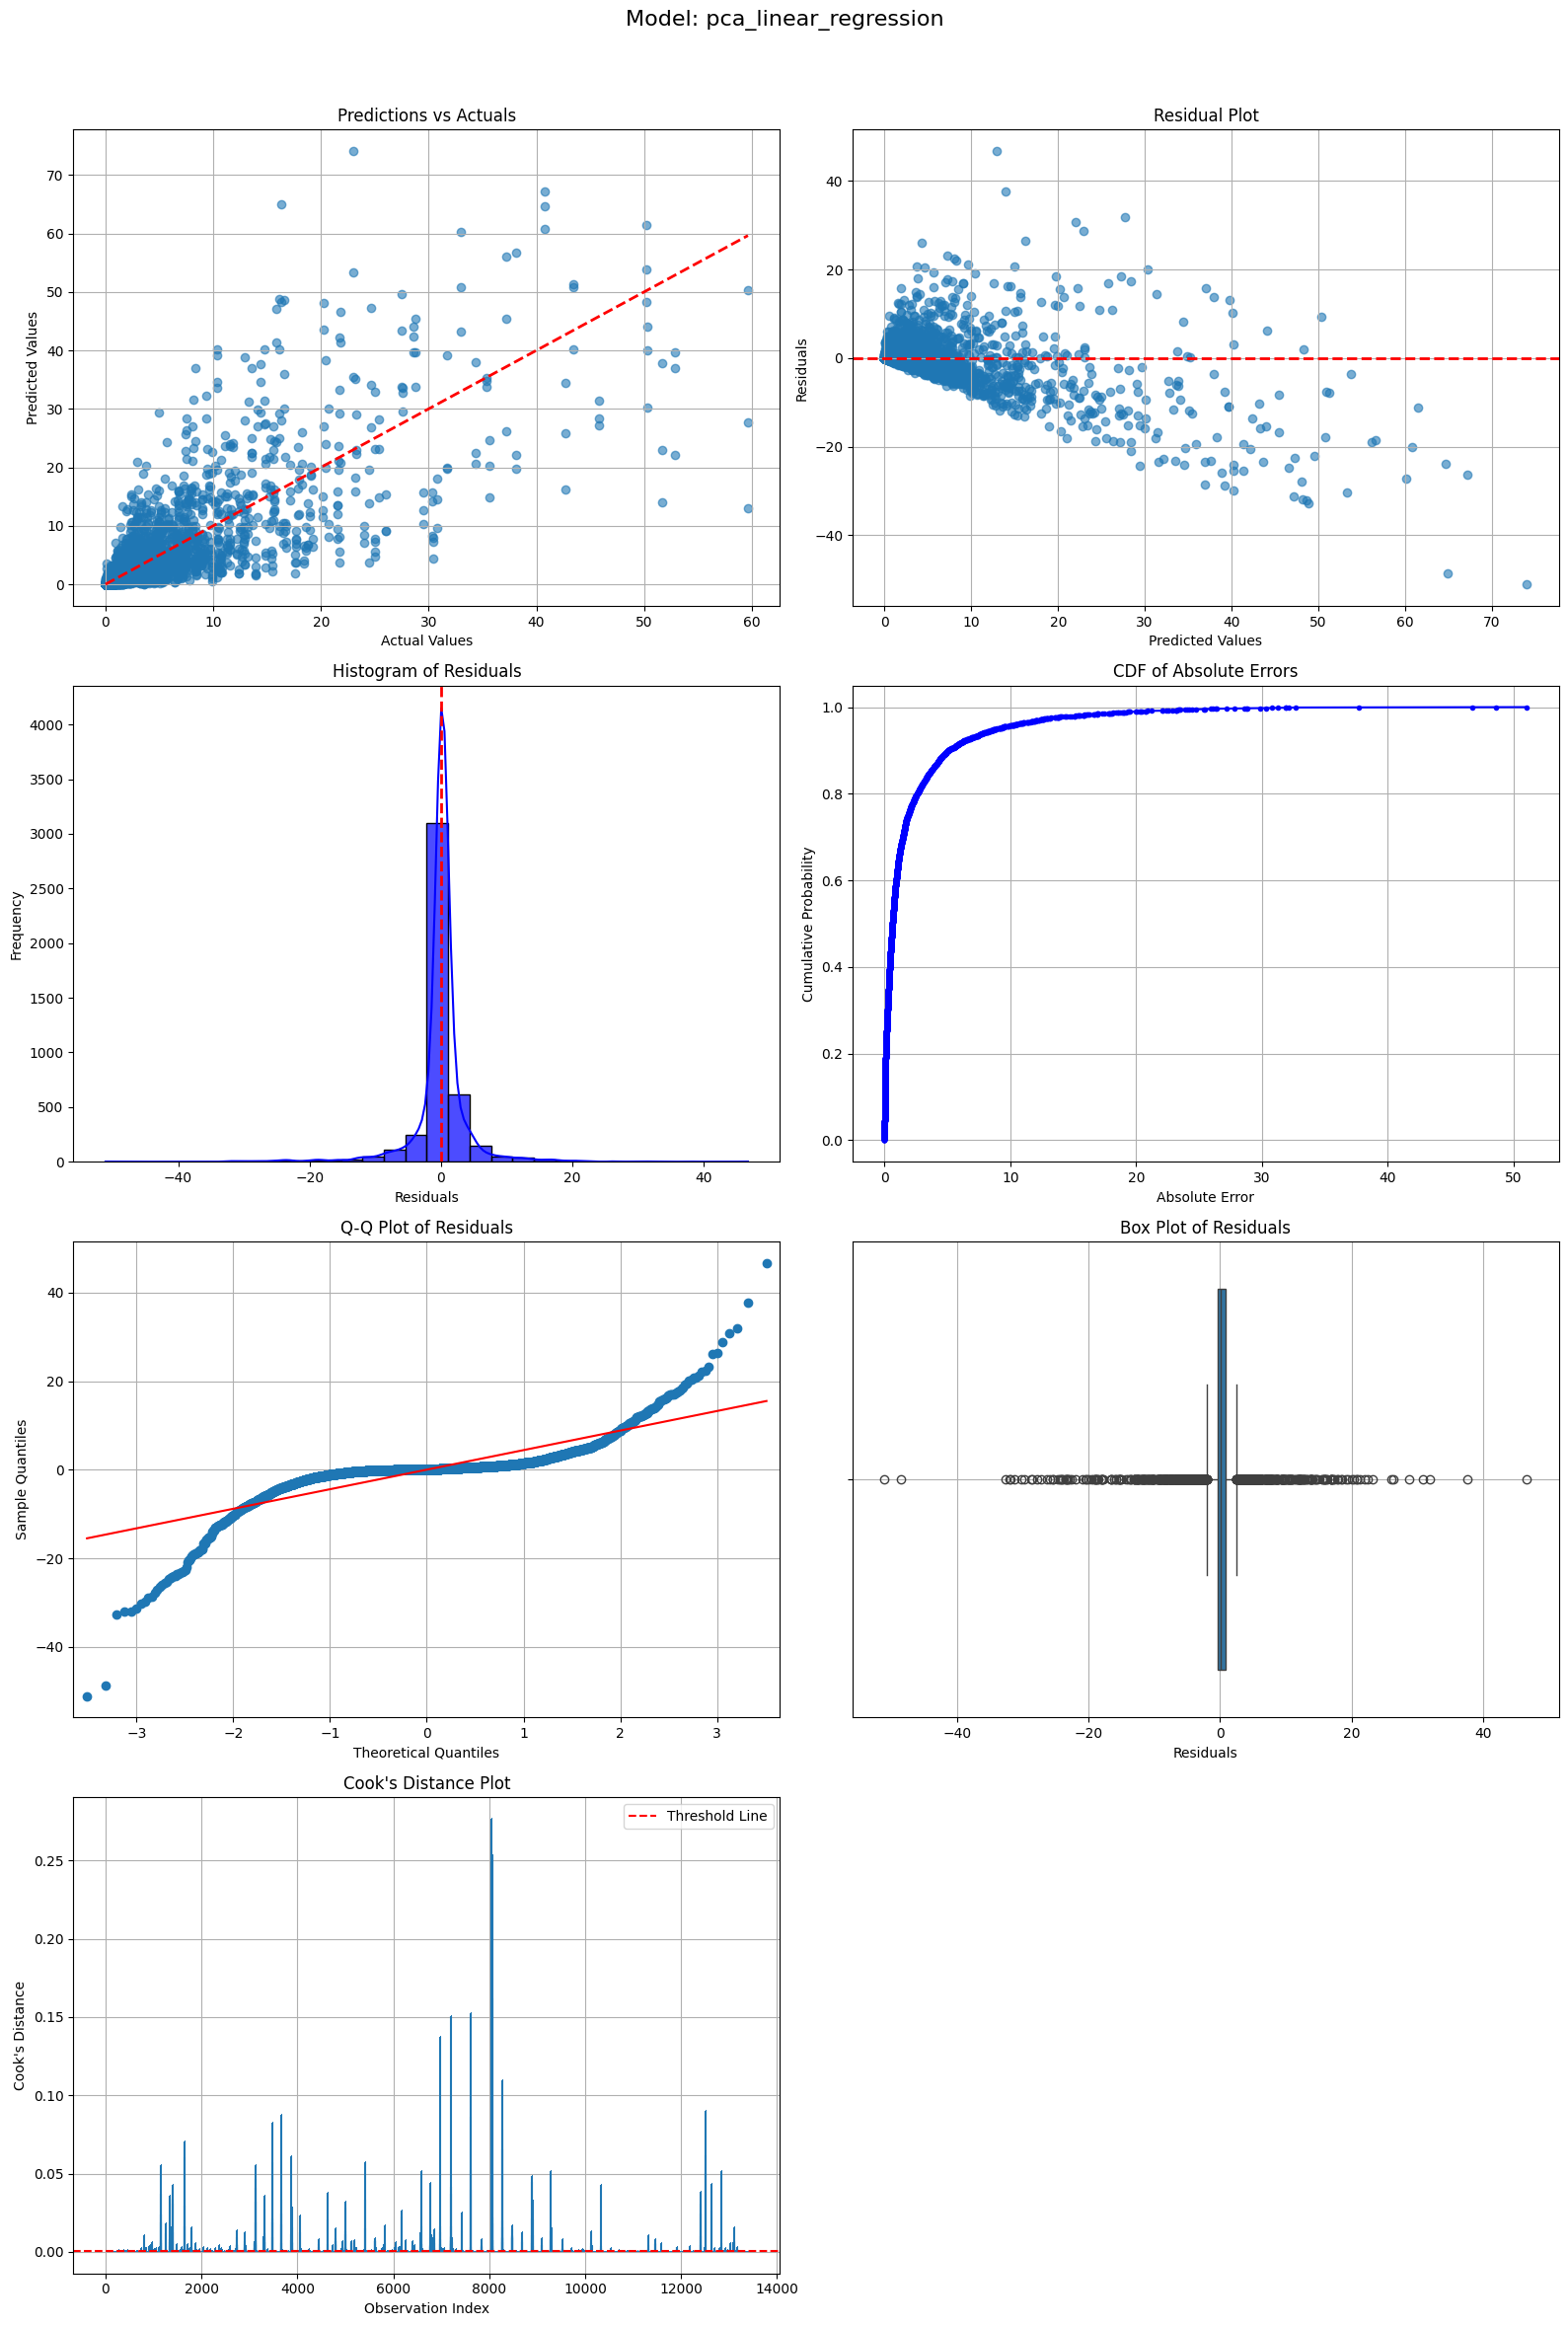

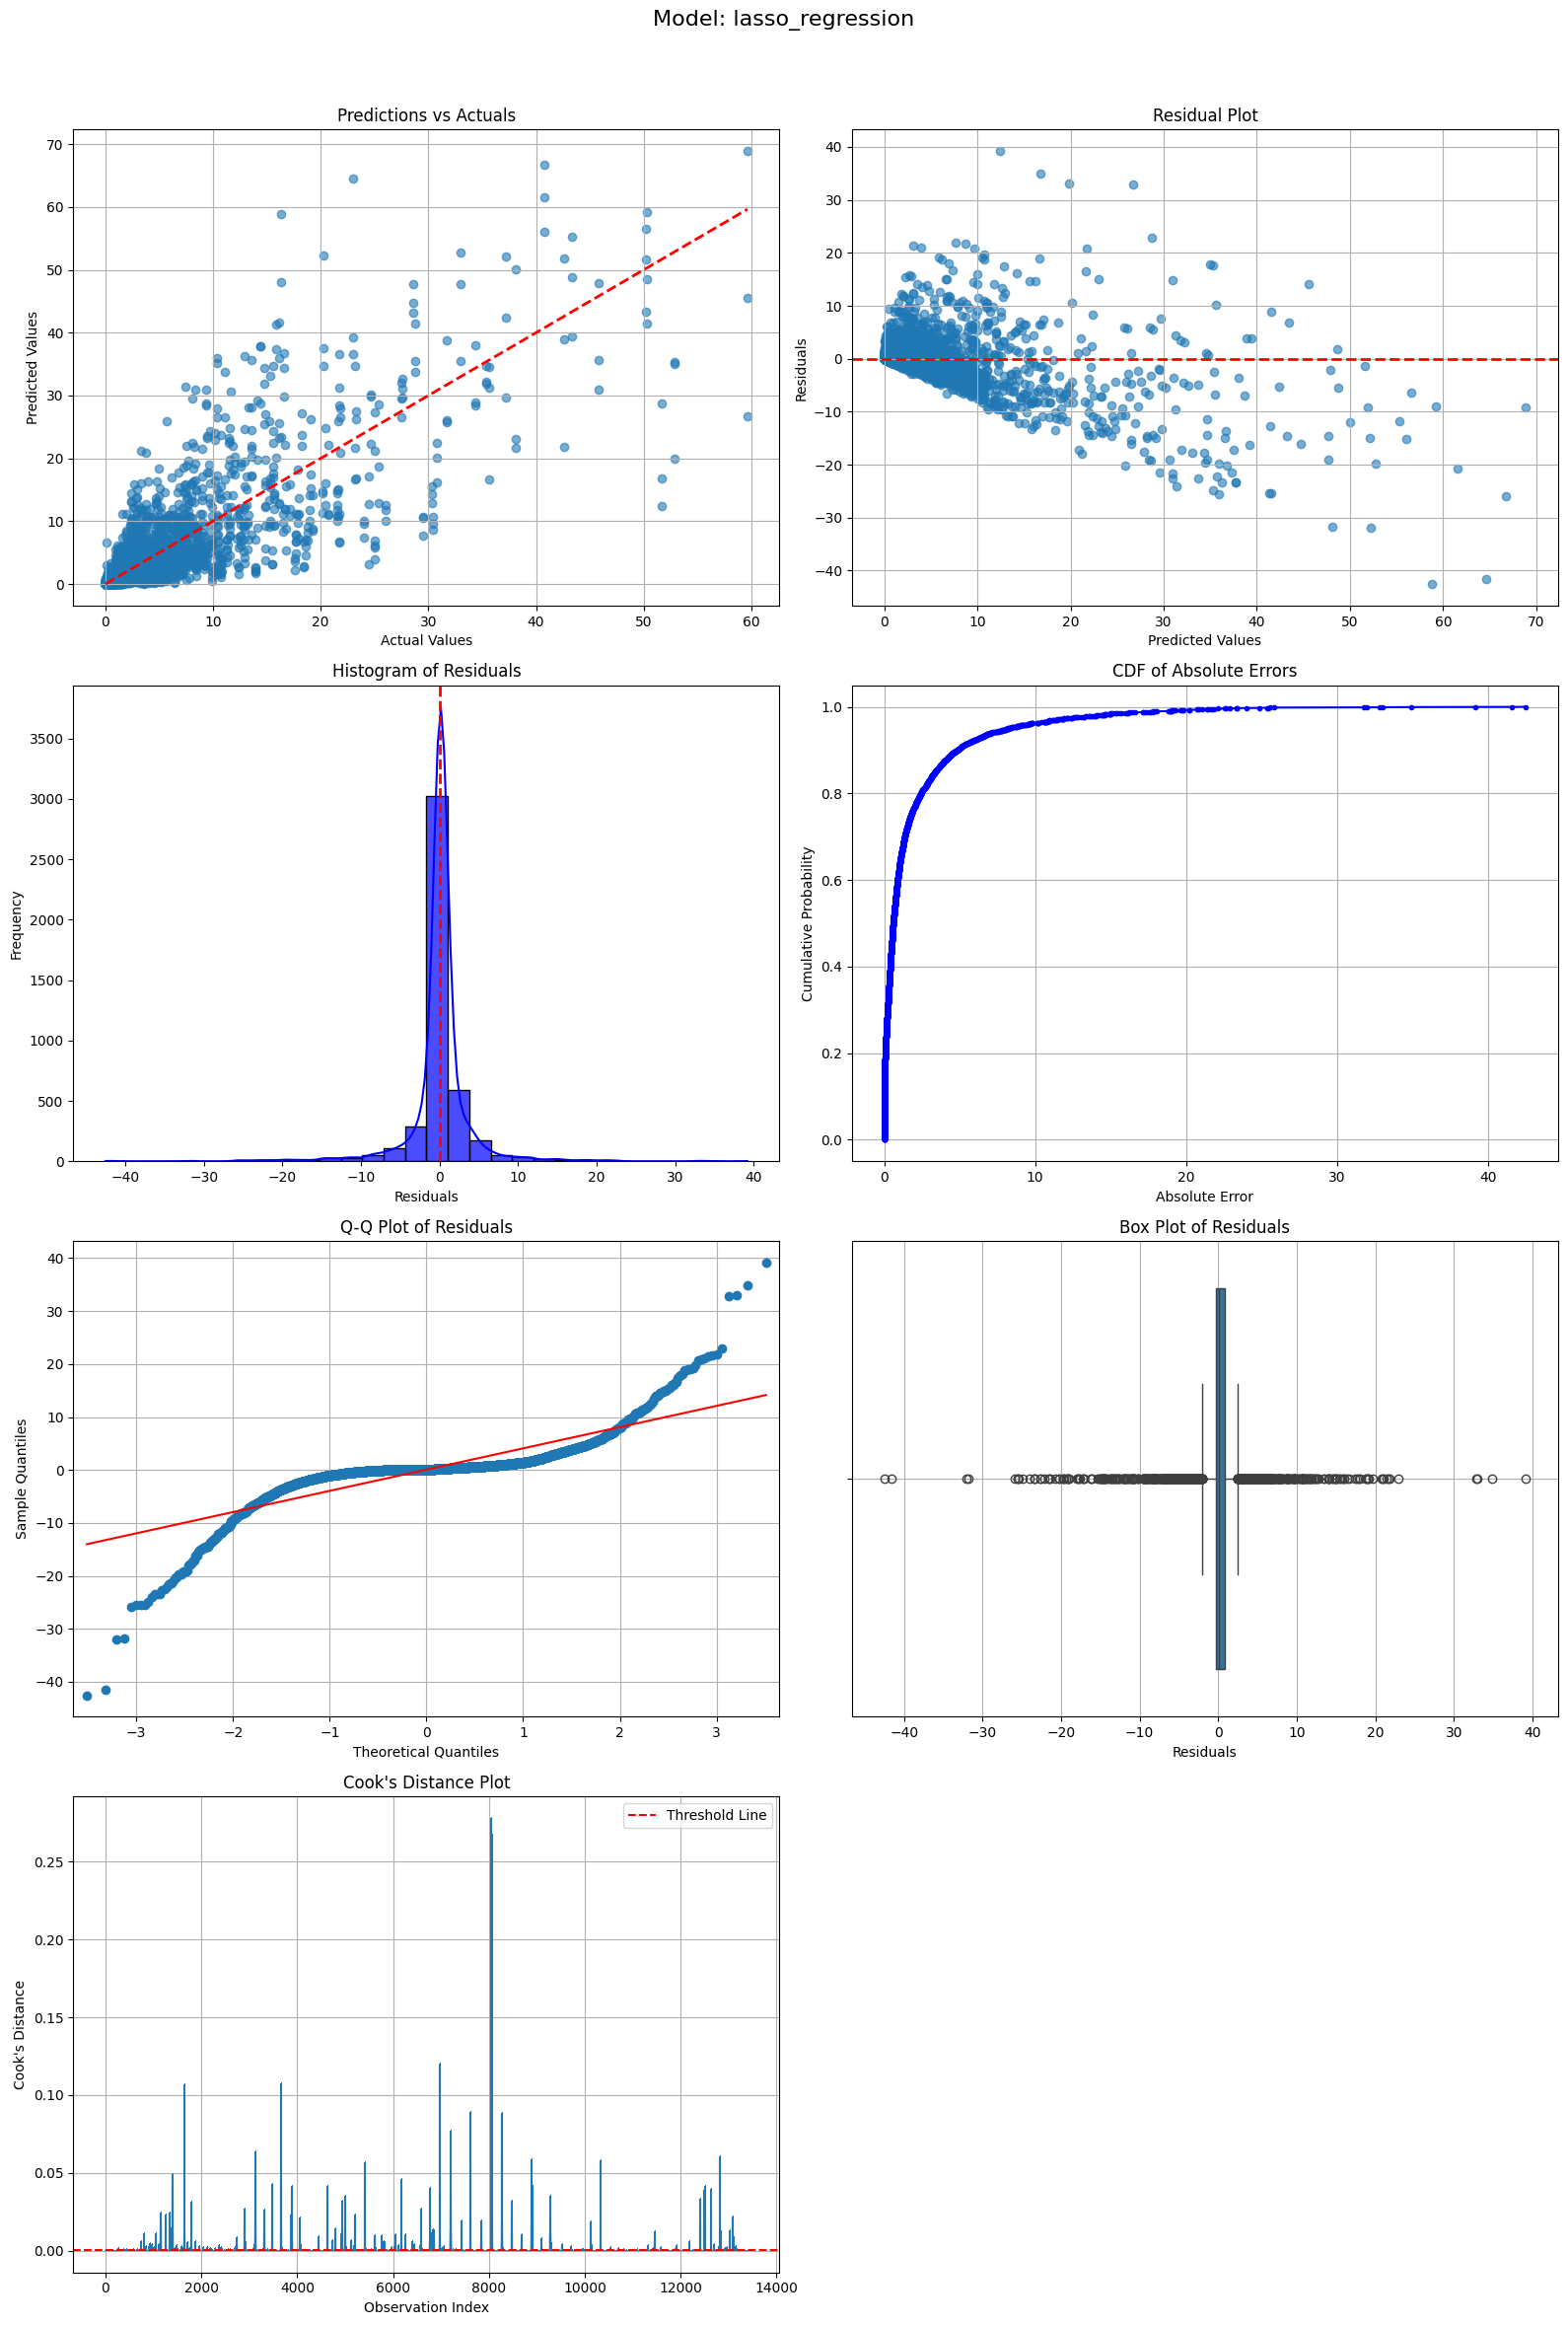

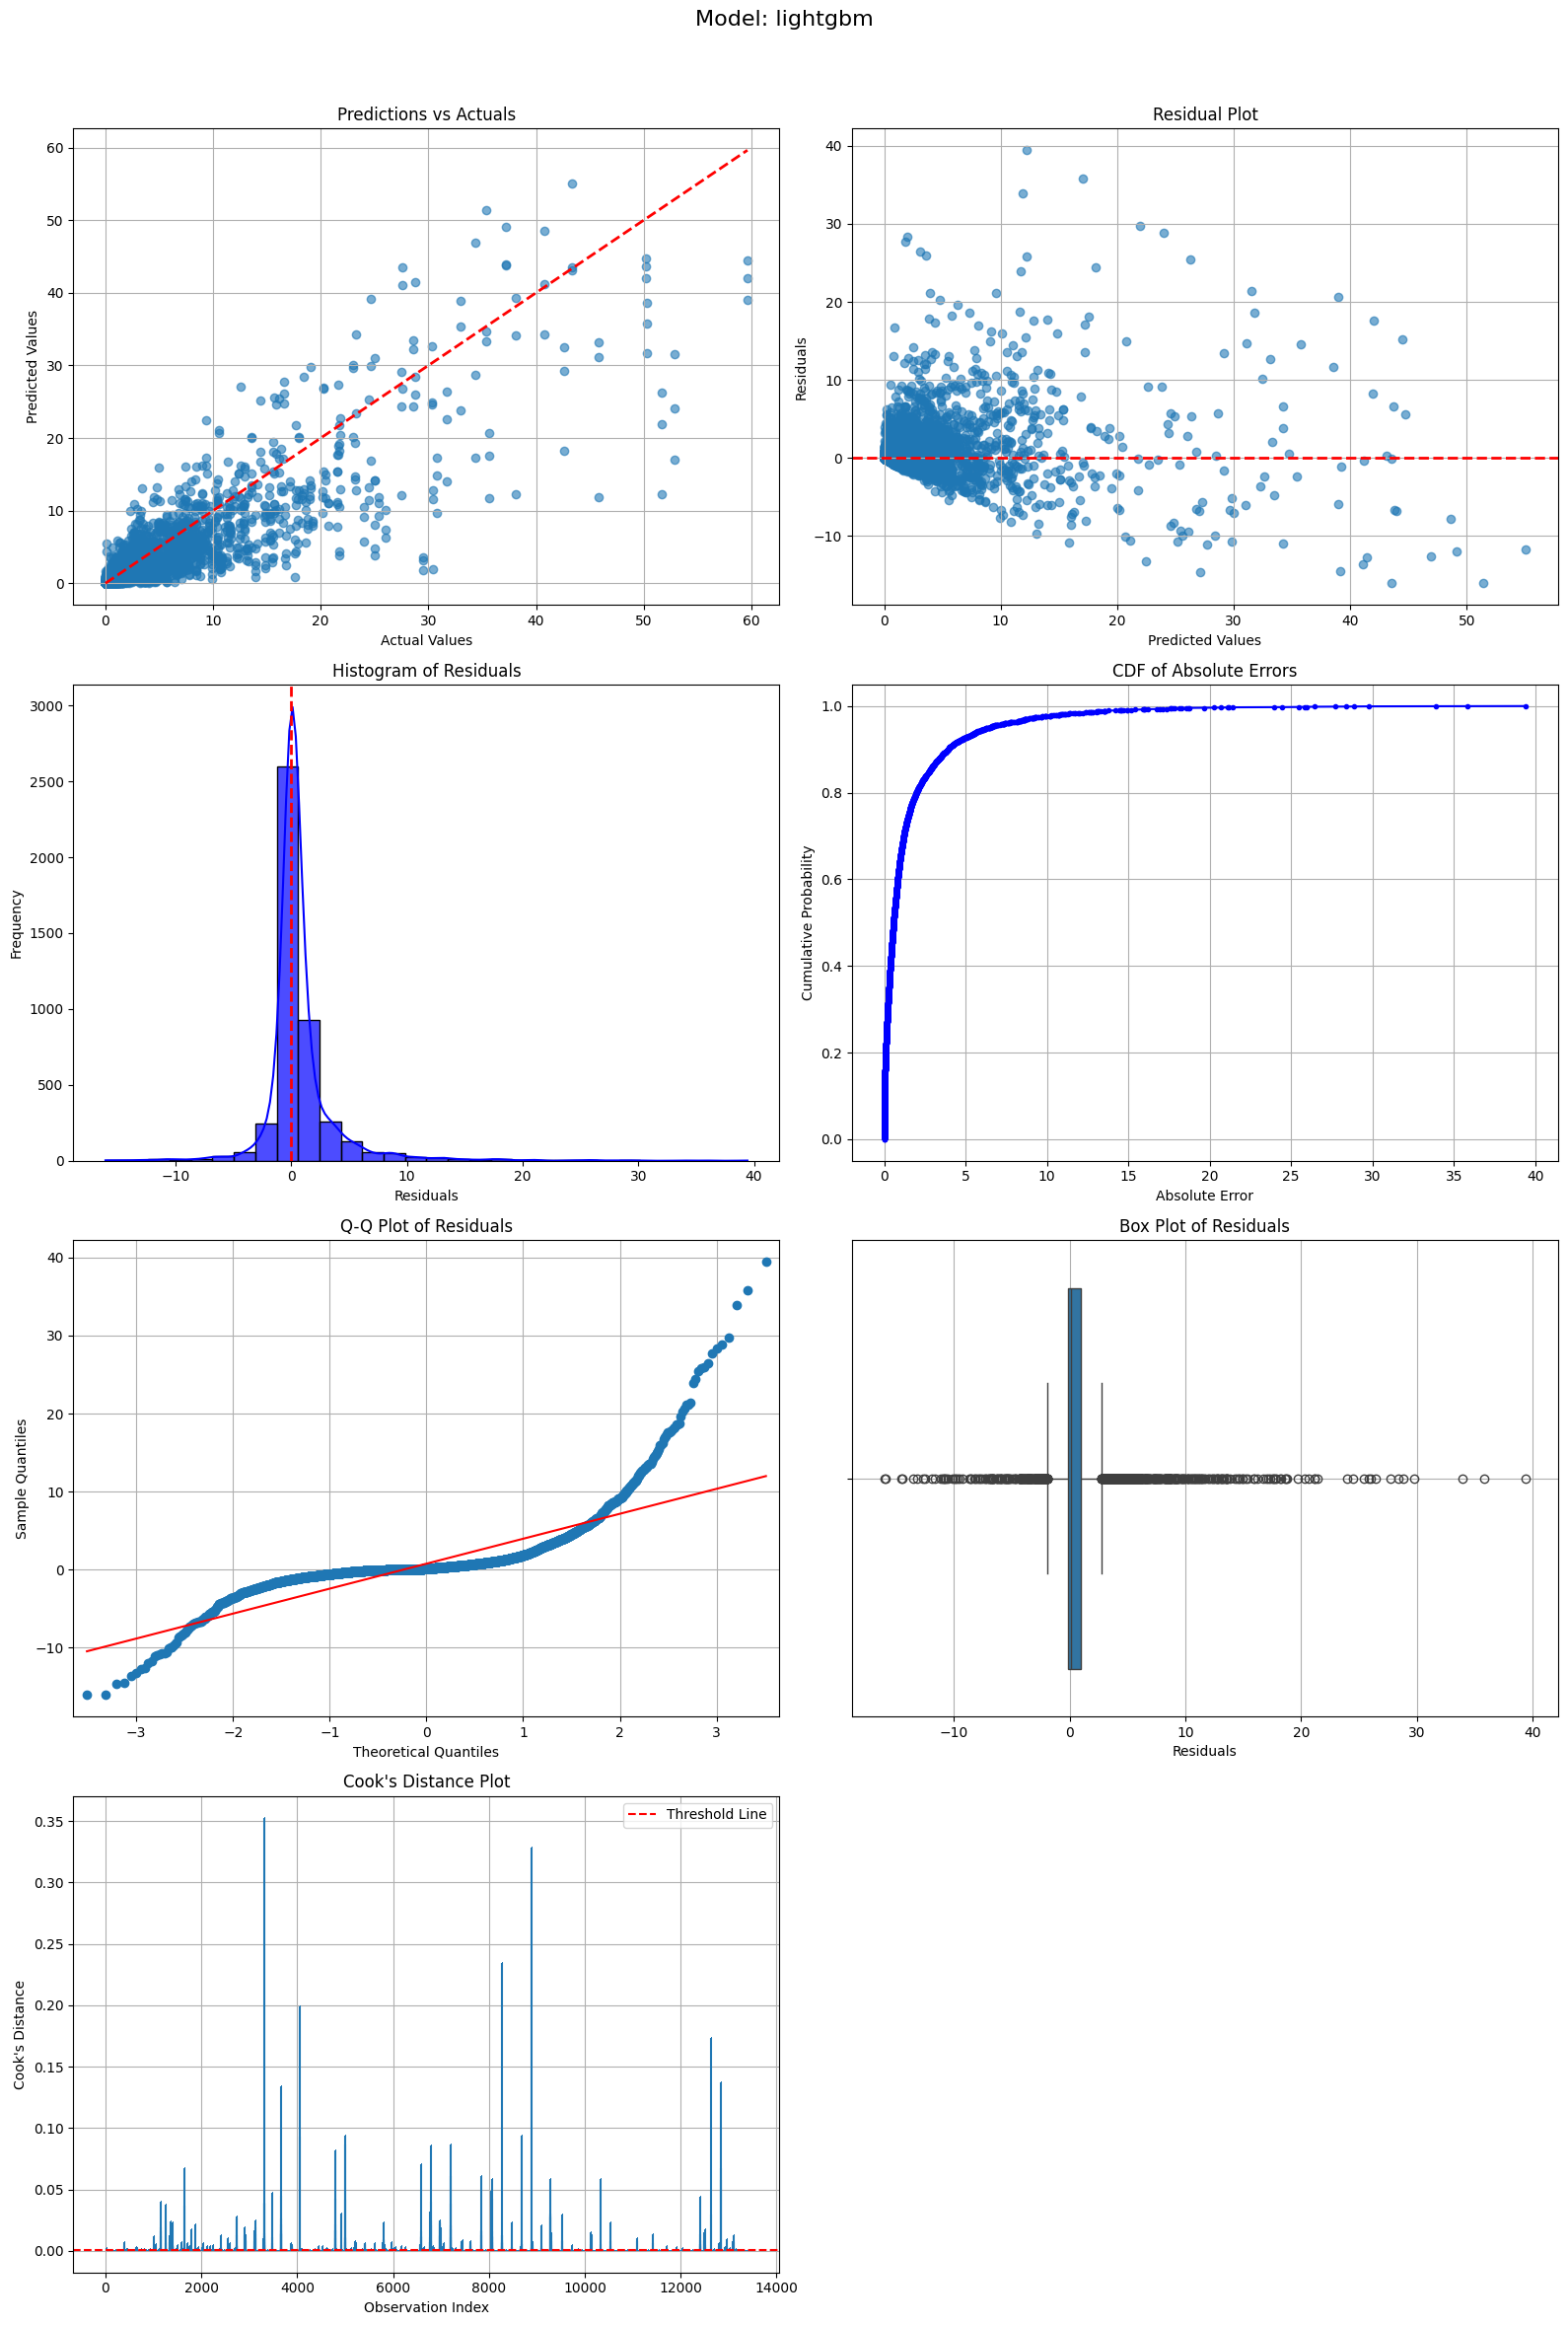

In [61]:
# Faceted plots for all models
for model_name, model in models.items():
    if model_name == 'pca_linear_regression':
        y_pred = inverse_transform_fun(model.predict(X_test_pca), scaler=1/100, epsilon=10e-6)
        y_pred_train = inverse_transform_fun(model.predict(X_train_pca), 'logit', scaler=1/100, epsilon=10e-6)
    elif model_name == 'baseline':  
        y_pred = np.full_like(y_test, y_train.mean(), dtype=np.float64)
        y_pred_train = np.full_like(y_train, y_train.mean(), dtype=np.float64)
    else:
        y_pred = inverse_transform_fun(model.predict(X_test), 'logit', scaler=1/100, epsilon=10e-6)
        y_pred_train = inverse_transform_fun(model.predict(X_train), 'logit', scaler=1/100, epsilon=10e-6)
        # if y_pred.ndim == 1:  
        #     y_pred = y_pred.reshape(-1, 1)
        # if y_pred_train.ndim == 1:
        #     y_pred_train = y_pred_train.reshape(-1, 1)

    # Define figure and axes for subplots (4 rows x 2 columns for 7 plots + title)
    fig, axs = plt.subplots(4, 2, figsize=(16, 24)) 
    fig.suptitle(f"Model: {model_name}", fontsize=16)
    
    # List of plot functions and titles
    plot_functions = [
        (plot_predictions_vs_actuals, "Predictions vs Actuals"),
        (plot_residuals, "Residual Plot"),
        (plot_residual_histogram, "Histogram of Residuals"),
        (plot_cdf_of_absolute_errors, "CDF of Absolute Errors"),
        (plot_qq_plot, "Q-Q Plot of Residuals"),
        (plot_residuals_boxplot, "Box Plot of Residuals"),
        (plot_cooks_distance, "Cook's Distance Plot")
    ]
    
    # Generate each plot directly in the subplot
    for i, (plot_func, title) in enumerate(plot_functions):
        row, col = divmod(i, 2)  # Determine subplot position
        ax = axs[row, col]
        if title != "Cook's Distance Plot":
            plot_func(y_test, y_pred, title=title, ax=ax) 
        else:
            # Cook's Distance is a measure of the influence of points on the model,
            # so it is calculated with the training data, not the test data.
            plot_func(y_train, y_pred_train, title=title, ax=ax) 

    # Remove the last empty subplot if fewer than 8 plots
    if len(plot_functions) < 8:
        fig.delaxes(axs[3, 1])  # Remove the last (4th row, 2nd column) plot
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout and title spacing
    plt.show()

In [62]:
# Generate a summary DataFrame with all metrics
metrics_summary = {
    'Model': [],
    'RMSE': [],
    'MAE': [],
    'R^2': [],
    'sMAPE': []
}

for model_name, model in models.items():
    if model_name == 'pca_linear_regression':
        y_pred = inverse_transform_fun(model.predict(X_test_pca), 'logit', scaler=1/100, epsilon=10e-6)
    elif model_name == 'baseline':  
        y_pred = np.full_like(y_test, y_train.mean(), dtype=np.float64)
    else:
        y_pred = inverse_transform_fun(model.predict(X_test), 'logit', scaler=1/100, epsilon=10e-6)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    smape_value = smape(y_test.values.ravel(), y_pred)

    metrics_summary['Model'].append(model_name)
    metrics_summary['RMSE'].append(rmse)
    metrics_summary['MAE'].append(mae)
    metrics_summary['R^2'].append(r2)
    metrics_summary['sMAPE'].append(smape_value)

# Create a DataFrame for summary
metrics_df = pd.DataFrame(metrics_summary)
print(metrics_df)


                   Model      RMSE       MAE       R^2       sMAPE
0               baseline  6.227590  3.418912 -0.003194  105.942059
1      linear_regression  4.270622  1.911666  0.528233   85.580968
2  pca_linear_regression  4.415851  1.988783  0.495602   87.385255
3       lasso_regression  4.012070  1.851577  0.583628   85.106707
4               lightgbm  3.288466  1.534487  0.720275   83.144651


### Model Comparison and Selection

Based on the evaluation metrics computed for each model, we can assess the performance and make an informed decision on the most suitable model. Here’s a summary of each metric and its interpretation:

| Metric | Description | Best Model (Value) | Interpretation |
|--------|-------------|--------------------|----------------|
| **RMSE** | Root Mean Squared Error (sensitive to large errors) | Lasso Regression (2.5538) | Lower RMSE indicates better performance, penalizing larger deviations more. Lasso Regression achieves the lowest RMSE, meaning it has fewer large errors. |
| **MAE** | Mean Absolute Error (average magnitude of errors) | LightGBM (1.3936) | Lower MAE indicates smaller average errors. LightGBM has the lowest MAE, suggesting it performs best in terms of overall accuracy on average. |
| **R²** | Proportion of variance explained by the model | Lasso Regression (0.8019) | Higher R² indicates that the model explains more variance in the data. Lasso Regression explains about 80.19% of the target variance, the highest among all models. |
| **sMAPE** | Symmetric Mean Absolute Percentage Error (percentage error measure) | LightGBM (80.24) | Lower sMAPE indicates that predictions are closer to actual values relative to their size. LightGBM performs best on this metric, showing relatively smaller percentage errors. |

### Model Selection Based on Metric Prioritization

#### 1. **If minimizing large errors is critical**:
   - **Lasso Regression** is the best choice due to its lowest RMSE and highest R², making it more sensitive to large deviations and better at explaining variance.

#### 2. **If overall accuracy (average error) is the primary goal**:
   - **LightGBM** is preferred, given its lowest MAE and lowest sMAPE, indicating it makes smaller errors on average and performs better when considering percentage errors.

#### 3. **If interpretability is important**:
   - Linear models, such as **Lasso Regression** and **Linear Regression**, offer more interpretability compared to **LightGBM**.
   - **Lasso Regression** provides a balance between interpretability and performance.

### Recommendation

- **If interpretability and model simplicity are less important**: Choose **LightGBM** for its strong performance across MAE and sMAPE. It provides a good balance across metrics, especially for minimizing average error.
  
- **If interpretability and understanding feature impacts are key**: **Lasso Regression** is an excellent choice, providing robust performance with interpretable coefficients.

In conclusion, **LightGBM** is the recommended model if minimizing errors is the primary objective, as it balances high performance across RMSE, MAE, and sMAPE. However, for more transparent analysis and insight into feature impacts, **Lasso Regression** provides similar performance with enhanced interpretability.


In [ ]:
y_test.describe()

### Error Analysis in Context of Target Distribution

To assess whether the error ranges (RMSE and MAE) of the best-performing models—**LightGBM** and **Lasso Regression**—are reasonable, we can compare these metrics against the distribution of the target variable in our data.

#### Interpretation of Target Distribution

- **Mean and Median**: The mean is **3.13** and the median is **1.28**, indicating that the distribution is positively skewed, with most values concentrated on the lower end.
  
- **Standard Deviation**: A standard deviation of **5.74** suggests considerable variability in the target values, implying that there are higher values that create a spread around the mean.

- **Percentiles**: With the 75th percentile at **3.11**, 75% of target values fall below this threshold, while the maximum value reaches **53.23**—indicating some high outliers that could skew the distribution.

#### Comparison with Model Error Metrics

The best models yielded the following error metrics:

| Model               | RMSE   | MAE   |
|---------------------|--------|-------|
| **LightGBM**        | 2.60   | 1.39  |
| **Lasso Regression**| 2.55   | 1.73  |

1. **RMSE Comparison**:
   - The RMSE values (around **2.55 to 2.60**) are reasonable given the target’s variability, especially as they are below the standard deviation (**5.74**) of the target variable. This suggests the models handle larger errors effectively, even with the presence of high outliers.
   
2. **MAE Comparison**:
   - The MAE values (between **1.39 and 1.73**) indicate that the average absolute error is close to the median value of **1.28**, suggesting that typical prediction errors are proportionate to the typical values in the data.
   - **LightGBM**, with an MAE of **1.39**, shows particularly good performance in minimizing average error.

3. **Outliers and Error Sensitivity**:
   - The maximum value of the target variable (**53.23**) is significantly higher than most other values, and errors for these extreme cases can inflate RMSE. Despite this, both models keep RMSE and MAE within a reasonable range, suggesting robust performance even with some outliers.

#### Conclusion

The error metrics for **LightGBM** and **Lasso Regression** are reasonable in the context of the target variable’s distribution:

- **LightGBM** has a slightly better MAE, indicating stronger performance in minimizing average errors across typical values.
- **Lasso Regression** achieves a marginally lower RMSE, suggesting it may handle outliers somewhat better.

In summary, both models exhibit error metrics that are proportionate to the distribution of the target variable, with **LightGBM** and **Lasso Regression** providing effective performance across typical values and outliers. This makes them both strong candidates for the task, depending on whether average accuracy (MAE) or outlier sensitivity (RMSE) is prioritized.
